# GAN-MNIST

Epoch [1/10]


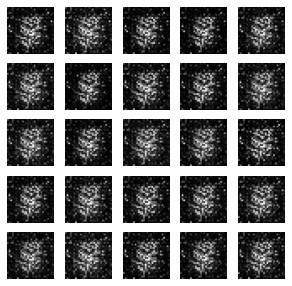

Epoch [2/10]


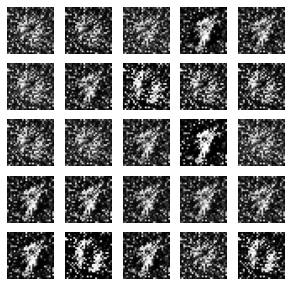

Epoch [3/10]


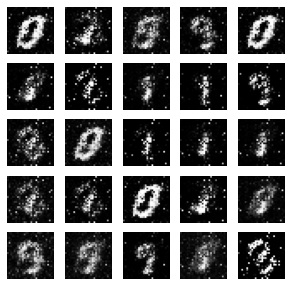

Epoch [4/10]


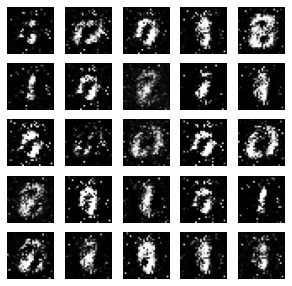

Epoch [5/10]


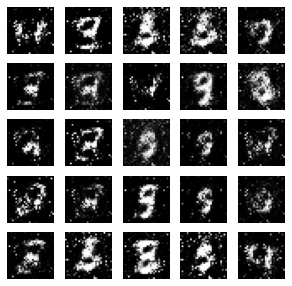

Epoch [6/10]


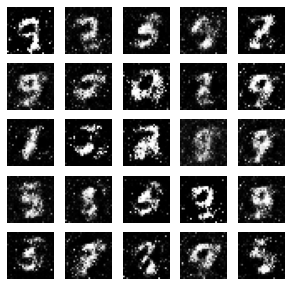

Epoch [7/10]


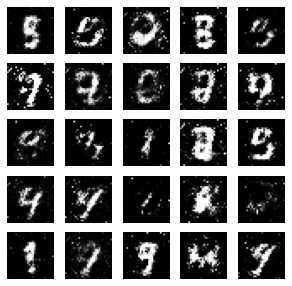

Epoch [8/10]


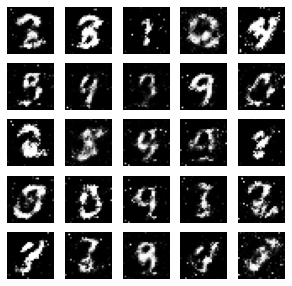

Epoch [9/10]


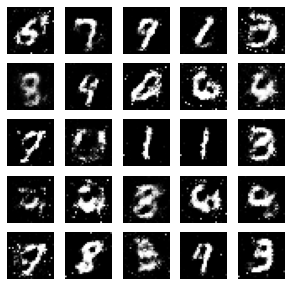

Epoch [10/10]


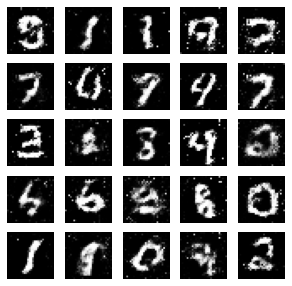

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Definición del generador
class Generator(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = keras.Sequential([
            layers.Dense(256, input_dim=latent_dim),
            layers.LeakyReLU(0.2),
            layers.Dense(512),
            layers.LeakyReLU(0.2),
            layers.Dense(1024),
            layers.LeakyReLU(0.2),
            layers.Dense(784, activation='tanh')
        ])

    def call(self, inputs):
        return self.model(inputs)

# Definición del discriminador
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = keras.Sequential([
            layers.Dense(512, input_dim=784),
            layers.LeakyReLU(0.2),
            layers.Dense(256),
            layers.LeakyReLU(0.2),
            layers.Dense(1, activation='sigmoid')
        ])

    def call(self, inputs):
        return self.model(inputs)

# Definición de la clase GAN
class GAN:
    def __init__(self, latent_dim):
        self.latent_dim = latent_dim

        self.generator = Generator(latent_dim)
        self.discriminator = Discriminator()
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy()

        self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    @tf.function
    def train_step(self, images):
        noise = tf.random.normal([images.shape[0], self.latent_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

    def train(self, dataset, epochs):
        for epoch in range(epochs):
            for image_batch in dataset:
                self.train_step(image_batch)

            if (epoch + 1) % 1 == 0:
                print(f"Epoch [{epoch+1}/{epochs}]")

                # Generar y mostrar imágenes generadas
                noise = tf.random.normal([25, self.latent_dim])
                generated_images = self.generator(noise, training=False)

                fig, axes = plt.subplots(5, 5, figsize=(5, 5))
                count = 0
                for i in range(5):
                    for j in range(5):
                        axes[i, j].imshow(generated_images[count].numpy().reshape(28, 28), cmap='gray')
                        axes[i, j].axis('off')
                        count += 1
                plt.show()

# Configuración de parámetros
latent_dim = 100
batch_size = 64
epochs = 10

# Cargar y preparar datos de entrenamiento
(train_images, _), (_, _) = keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 784).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(batch_size)

# Creación del objeto GAN
gan = GAN(latent_dim)

# Entrenamiento de la red GAN
gan.train(train_dataset, epochs)

# GAN-CelebA

Files already downloaded and verified
Epoch [1/10] Loss_D: 0.9193 Loss_G: 1.6013


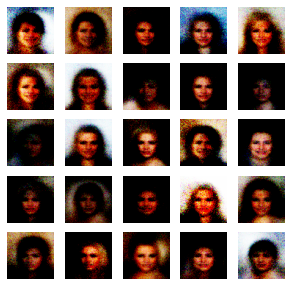

Epoch [2/10] Loss_D: 0.6178 Loss_G: 1.1614


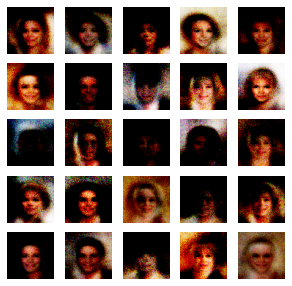

Epoch [3/10] Loss_D: 0.6356 Loss_G: 1.2467


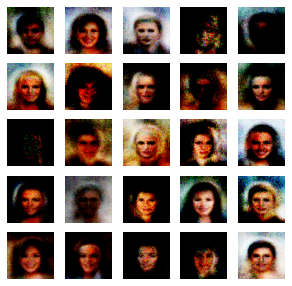

Epoch [4/10] Loss_D: 0.7051 Loss_G: 1.2729


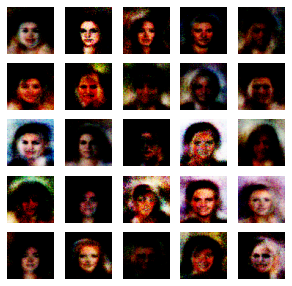

Epoch [5/10] Loss_D: 0.6482 Loss_G: 0.7640


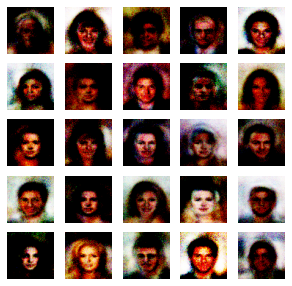

Epoch [6/10] Loss_D: 0.6230 Loss_G: 0.9111


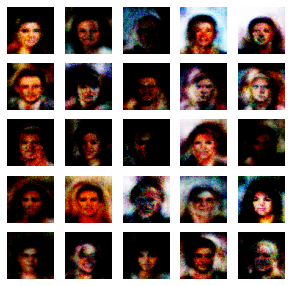

Epoch [7/10] Loss_D: 0.6479 Loss_G: 0.6294


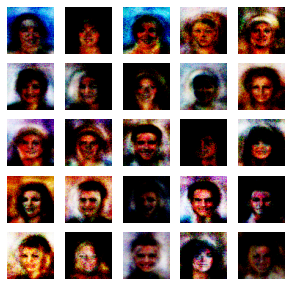

Epoch [8/10] Loss_D: 0.6799 Loss_G: 0.6787


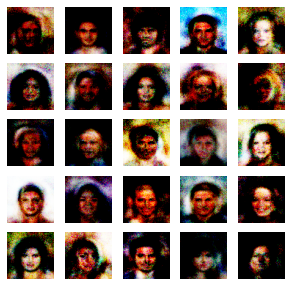

Epoch [9/10] Loss_D: 0.6200 Loss_G: 0.8650


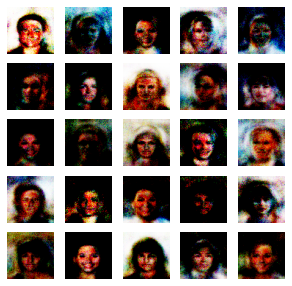

Epoch [10/10] Loss_D: 0.7083 Loss_G: 0.7895


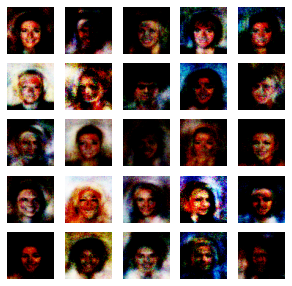

In [22]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Definición del generador
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Definición del discriminador
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Definición de la clase GAN
class GAN:
    def __init__(self, latent_dim, img_shape, device):
        self.latent_dim = latent_dim
        self.img_shape = img_shape
        self.device = device

        self.generator = Generator(latent_dim, img_shape).to(device)
        self.discriminator = Discriminator(img_shape).to(device)
        self.criterion = nn.BCELoss()

        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def train(self, dataloader, num_epochs):
        for epoch in range(num_epochs):
            for i, (real_imgs, _) in enumerate(dataloader):
                batch_size = real_imgs.size(0)
                valid = torch.ones(batch_size, 1).to(self.device)
                fake = torch.zeros(batch_size, 1).to(self.device)

                # Entrenamiento del discriminador
                self.optimizer_D.zero_grad()

                real_imgs = real_imgs.to(self.device)
                real_loss = self.criterion(self.discriminator(real_imgs), valid)

                z = torch.randn(batch_size, self.latent_dim).to(self.device)
                gen_imgs = self.generator(z)
                fake_loss = self.criterion(self.discriminator(gen_imgs.detach()), fake)

                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                self.optimizer_D.step()

                # Entrenamiento del generador
                self.optimizer_G.zero_grad()

                z = torch.randn(batch_size, self.latent_dim).to(self.device)
                gen_imgs = self.generator(z)

                g_loss = self.criterion(self.discriminator(gen_imgs), valid)

                g_loss.backward()
                self.optimizer_G.step()

            if (epoch+1) % 1 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D: {d_loss.item():.4f} Loss_G: {g_loss.item():.4f}")

                # Generar y mostrar imágenes generadas
                self.generator.eval()
                with torch.no_grad():
                    z = torch.randn(25, self.latent_dim).to(self.device)
                    gen_imgs = self.generator(z).cpu()

                fig, axes = plt.subplots(5, 5, figsize=(5, 5))
                for i, ax in enumerate(axes.flatten()):
                    ax.imshow(gen_imgs[i].permute(1, 2, 0))
                    ax.axis('off')
                plt.show()
                self.generator.train()

# Configuración de parámetros
latent_dim = 100
img_shape = (3, 64, 64)  # Imágenes de CelebA tienen 3 canales (RGB)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creación del objeto GAN
gan = GAN(latent_dim, img_shape, device)

# Cargar datos de entrenamiento
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
celeba_dataset = datasets.CelebA(root='data', split='train', transform=transform, download=True)
dataloader = DataLoader(celeba_dataset, batch_size=64, shuffle=True)

# Entrenamiento de la red GAN
num_epochs = 10
gan.train(dataloader, num_epochs)

### Informe 

Para empezar a desarrollar la Red Generativa Adversaria utilicé los cuadernos del Diplomado y recursos externos de Internet para aclarar conceptos que no tenía del todo claros. Luego busque que frameworks de desarrollo de Inteligencia Artificial contaban con los datasets necesarios (MINST y CelebA), utilicé un codigo incial que con ayuda de chatgpt de OpenIA y Bard de Google logre mejorar, debido a esta mejora tuve problemas con la carga de base de datos de celebA con el paquete tensorflow lo cual solucioné utilizando PyTorch para desarrollar la red con esta base de datos, otro problema que encontré es el tiempo de entrenamiento de la res GAN-CelebA, pues para 10 iteraciones demoró un total de 141 minutos .

### Mis conclusiones
-   La red Gan es eficiente para entrenarse y crear imagenes nuevas con imagenes en blanco y negro o con escalas de grises 
mientras que tomando una imagen de colores puede demorarse hasta 10 veceses más. 
-   Al probar los dos paquetes (keras y Pytorch) para la generacion de redes adversas las redes creadas con Tensorflow fueron sustancialmente más rapidas que las creadas con pytorch .
-  Los modelos de lenguaje como Chatgpt o Bard son utiles para optimizar el código en este tipo de problemas, señalando especificamente donde se encuentra el error del codigo.
### Bibliografía 
-   AprendizajeProfundo. (n.d.). Diplomado/GAN.ipynb at master · AprendizajeProfundo/Diplomado. GitHub. https://github.com/AprendizajeProfundo/Diplomado/blob/master/Temas/M%C3%B3dulo%2007%20-%20Visi%C3%B3n%20por%20computador/06%20-%20Redes%20generativas%20adversarias/Cuadernos/GAN.ipynb
- Brownlee, J. (2020). How to Develop a GAN for Generating MNIST Handwritten Digits. MachineLearningMastery.com. https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/
- Kaushiklade. (2022, January 7). Image Generation using Generative Adversarial Networks (GANs). Medium. https://medium.com/mlearning-ai/image-generation-using-generative-adversarial-networks-gans-cd82afd71597